In [64]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
#   DataGenerator to read images and rescale images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [65]:
import os

# Get the current working directory
working_directory = "/kaggle/input/mri-alzheimer-dataset/Dataset"

# List the contents of the working directory
contents = os.listdir(working_directory)

# Print the contents of the working directory
print("Contents of the working directory:")
for item in contents:
    print(item)


Contents of the working directory:
Non_Demented
Mild_Demented
Moderate_Demented
Very_Mild_Demented


In [66]:
# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [67]:
## Set Path Here before running the code
WORKINGDIRECTORY = "/kaggle/input/mri-alzheimer-dataset/Dataset"

##  Name of classes
CLASSES = ['Mild_Demented',
           'Moderate_Demented',
           'Non_Demented',
           'Very_Mild_Demented']

# Check if the directory exists
if os.path.exists(WORKINGDIRECTORY):
    # List the contents of the directory
    contents = os.listdir(WORKINGDIRECTORY)
    
    # Check if there are any files or subdirectories
    if len(contents) > 0:
        print("The working directory contains the following:")
        for item in contents:
            print(item)
    else:
        print("The working directory is empty.")
else:
    print("The specified directory does not exist.")


The working directory contains the following:
Non_Demented
Mild_Demented
Moderate_Demented
Very_Mild_Demented


In [68]:
X, y = [], []

# Images rescaling
datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images by resizing and shuffling randomly
train_dataset = datagen.flow_from_directory(WORKINGDIRECTORY, target_size=(150, 150), batch_size=6400, shuffle=True)

# Iterate over the train_dataset to retrieve batches of data
for batch in train_dataset:
    X_batch, y_batch = batch
    X.append(X_batch)
    y.append(y_batch)
    
    # Break the loop when all batches have been retrieved
    if len(X) * 6400 >= len(train_dataset):
        break

# Concatenate the batches to form the complete dataset
X = np.concatenate(X)
y = np.concatenate(y)


Found 6400 images belonging to 4 classes.


In [69]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)


# Number of samples after train test split
print("Number of samples after splitting into Training, validation & test set\n")

print("Train     \t",sorted(Counter(np.argmax(y_train, axis=1)).items()))
print("Validation\t",sorted(Counter(np.argmax(y_val, axis=1)).items()))
print("Test      \t",sorted(Counter(np.argmax(y_test, axis=1)).items()))

Number of samples after splitting into Training, validation & test set

Train     	 [(0, 627), (1, 42), (2, 2223), (3, 1588)]
Validation	 [(0, 223), (1, 17), (2, 772), (3, 524)]
Test      	 [(0, 46), (1, 5), (2, 205), (3, 128)]


In [70]:
print("Number of samples in each class:\t", sorted(Counter(np.argmax(y, axis=1)).items()))

#   class labels as per indices
print("Classes Names according to index:\t", train_dataset.class_indices)

Number of samples in each class:	 [(0, 896), (1, 64), (2, 3200), (3, 2240)]
Classes Names according to index:	 {'Mild_Demented': 0, 'Moderate_Demented': 1, 'Non_Demented': 2, 'Very_Mild_Demented': 3}


In [71]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4480, 150, 150, 3)
y_train shape: (4480, 4)
X_test shape: (384, 150, 150, 3)
y_test shape: (384, 4)


## RESNET

In [72]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Input, concatenate, Flatten, Dense, BatchNormalization

def create_resnet(input_shape):
    inputs = Input(input_shape)
    
    # First convolutional block
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Second convolutional block
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Flatten layer
    flat = Flatten()(pool2)
    
    # Dense layers
    dense1 = Dense(128, activation='relu')(flat)
    
    # Output layer
    outputs = Dense(4, activation='softmax')(dense1)  # 4 classes in the output layer

    # Create the model
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create ResNet model
model_resnet = create_resnet(input_shape=(150, 150, 3))

# Compile the model
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_resnet = model_resnet.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss_resnet, test_accuracy_resnet = model_resnet.evaluate(X_test, y_test)
print(f"ResNet Test Accuracy: {test_accuracy_resnet}, Test Loss: {test_loss_resnet}")


Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.4836 - loss: 20.9372 - val_accuracy: 0.5033 - val_loss: 2.4596
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6850 - loss: 2.8030 - val_accuracy: 0.5605 - val_loss: 3.1323
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8132 - loss: 0.8546 - val_accuracy: 0.7168 - val_loss: 0.8333
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8883 - loss: 0.4760 - val_accuracy: 0.6400 - val_loss: 1.9815
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9225 - loss: 0.2527 - val_accuracy: 0.8932 - val_loss: 0.4021
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9716 - loss: 0.0827 - val_accuracy: 0.9447 - val_loss: 0.2076
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9762 - loss: 0.0758 - val_accuracy: 0.9284 - val_loss: 0.2619
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9258 - loss: 0.3268 - val_acc

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


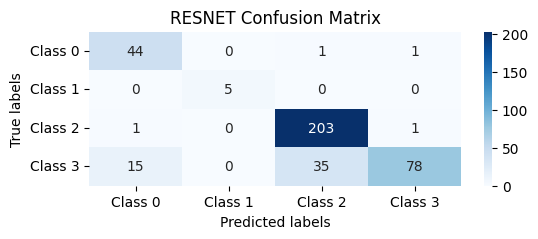

RESNET Classification Report:
              precision    recall  f1-score     support
0              0.733333  0.956522  0.830189   46.000000
1              1.000000  1.000000  1.000000    5.000000
2              0.849372  0.990244  0.914414  205.000000
3              0.975000  0.609375  0.750000  128.000000
accuracy       0.859375  0.859375  0.859375    0.859375
macro avg      0.889426  0.889035  0.873651  384.000000
weighted avg   0.879309  0.859375  0.850634  384.000000


In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
y_pred_probs = model_resnet.predict(X_test)

# Predicted classes
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# True classes
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('RESNET Confusion Matrix')
plt.show()

# Print classification report
print("RESNET Classification Report:")
report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)

# Convert dictionary to pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Print classification report as table
print(report_df)


# LeNet

In [74]:
# Define the model architecture (LeNet)
model_lenet = Sequential([
    Conv2D(6, (5, 5), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(16, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(4, activation='softmax')  # 4 classes in the output layer
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [75]:
# Compile the model
model_lenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## LeNet Training...

In [76]:
# Train the model with reshaped labels
history_lenet = model_lenet.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5080 - loss: 1.0230 - val_accuracy: 0.6745 - val_loss: 0.8074
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7206 - loss: 0.6465 - val_accuracy: 0.8385 - val_loss: 0.3969
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9067 - loss: 0.2682 - val_accuracy: 0.9193 - val_loss: 0.2185
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9798 - loss: 0.0772 - val_accuracy: 0.9219 - val_loss: 0.1976
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9951 - loss: 0.0254 - val_accuracy: 0.9505 - val_loss: 0.1358


In [77]:
# Evaluate the model on the test set
test_loss_lenet, test_accuracy_lenet = model_lenet.evaluate(X_test, y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9477 - loss: 0.1489


In [78]:
print(f"LeNet Test Accuracy: {test_accuracy_lenet}, Test Loss: {test_loss_lenet}")

LeNet Test Accuracy: 0.9505208134651184, Test Loss: 0.1358213871717453


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


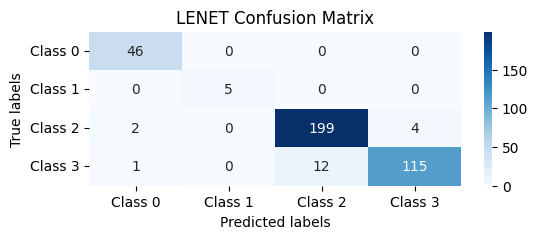

LENET Classification Report:
              precision    recall  f1-score     support
0              0.938776  1.000000  0.968421   46.000000
1              1.000000  1.000000  1.000000    5.000000
2              0.943128  0.970732  0.956731  205.000000
3              0.966387  0.898438  0.931174  128.000000
accuracy       0.950521  0.950521  0.950521    0.950521
macro avg      0.962073  0.967292  0.964081  384.000000
weighted avg   0.951100  0.950521  0.950176  384.000000


In [79]:
y_pred_probs = model_lenet.predict(X_test)

# Predicted classes
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# True classes
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('LENET Confusion Matrix')
plt.show()

# Print classification report
print("LENET Classification Report:")
report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)

# Convert dictionary to pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Print classification report as table
print(report_df)


# UNet

In [80]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, Input, concatenate, Flatten, Dense

In [81]:
# Define the model architecture (simplified U-Net)
def create_unet(input_shape):
    inputs = Input(input_shape)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    flat = Flatten()(pool2)
    dense1 = Dense(128, activation='relu')(flat)
    outputs = Dense(4, activation='softmax')(dense1)  # 4 classes in the output layer

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [82]:
# Create U-Net model
model_unet = create_unet(input_shape=(150, 150, 3))

In [83]:
# Compile the model
model_unet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## UNet Training

In [84]:
# Train the model
history_unet = model_unet.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.4286 - loss: 2.2790 - val_accuracy: 0.5820 - val_loss: 0.9361
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5614 - loss: 0.9162 - val_accuracy: 0.5384 - val_loss: 0.9653
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5798 - loss: 0.8932 - val_accuracy: 0.6100 - val_loss: 0.8434
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6503 - loss: 0.7621 - val_accuracy: 0.6660 - val_loss: 0.6911
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7180 - loss: 0.6403 - val_accuracy: 0.7207 - val_loss: 0.6377
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8136 - loss: 0.4473 - val_accuracy: 0.8164 - val_loss: 0.4566
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8834 - loss: 0.2866 - val_accuracy: 0.8086 - val_loss: 0.4689
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9151 - loss: 0.2209 - val_accu

In [85]:
# Evaluate the model on the test set
test_loss_unet, test_accuracy_unet = model_unet.evaluate(X_test, y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9371 - loss: 0.1887


## UNet Test-Accuracy and Test-Loss

In [86]:
print(f"U-Net Test Accuracy: {test_accuracy_unet}, Test Loss: {test_loss_unet}")

U-Net Test Accuracy: 0.921875, Test Loss: 0.20125456154346466


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


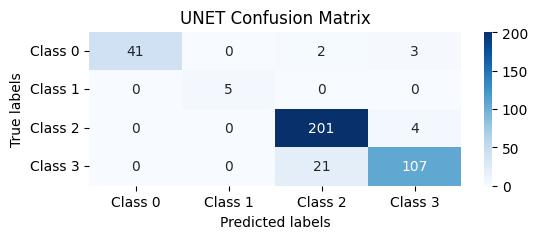

UNET Classification Report:
Classification Report:
              precision    recall  f1-score     support
0              1.000000  0.891304  0.942529   46.000000
1              1.000000  1.000000  1.000000    5.000000
2              0.897321  0.980488  0.937063  205.000000
3              0.938596  0.835938  0.884298  128.000000
accuracy       0.921875  0.921875  0.921875    0.921875
macro avg      0.958979  0.926932  0.940972  384.000000
weighted avg   0.924717  0.921875  0.920949  384.000000


In [87]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict probabilities for each class
y_pred_probs = model_unet.predict(X_test)

# Predicted classes
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# True classes
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('UNET Confusion Matrix')
plt.show()

# Print classification report
print("UNET Classification Report:")
report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)

# Convert dictionary to pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Print classification report as table
print("Classification Report:")
print(report_df)


# EfficientNet

In [88]:
from tensorflow.keras.applications import EfficientNetB0

# Create EfficientNetB0 model
model_efficientnet = EfficientNetB0(input_shape=(150, 150, 3), weights=None, classes=4)

In [89]:
# Compile the model
model_efficientnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Efficient-Net Training...

In [90]:
# Training with EarlyStopping
history_efficientnet = model_efficientnet.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 90s 121ms/step - accuracy: 0.4137 - loss: 2.6871 - val_accuracy: 0.5026 - val_loss: 1.1074
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.4774 - loss: 1.5094 - val_accuracy: 0.5026 - val_loss: 1.2808
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.4896 - loss: 1.3018 - val_accuracy: 0.3411 - val_loss: 1.0957
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.5601 - loss: 0.9839 - val_accuracy: 0.5026 - val_loss: 1.3878
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.6369 - loss: 0.8509 - val_accuracy: 0.5749 - val_loss: 0.9165
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.6943 - loss: 0.7209 - val_accuracy: 0.5983 - val_loss: 0.9694
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.8163 - loss: 0.4899 - val_accuracy: 0.7174 - val_loss: 0.7008
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.8698 - loss: 0.3586 -

In [91]:
# Evaluate the model on the test set
test_loss_efficientnet, test_accuracy_efficientnet = model_efficientnet.evaluate(X_test, y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2249 - loss: 7.3888


In [92]:
print(f"Efficient-Net Test Accuracy: {test_accuracy_efficientnet}, Test Loss: {test_loss_efficientnet}")

Efficient-Net Test Accuracy: 0.2265625, Test Loss: 7.277720928192139


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


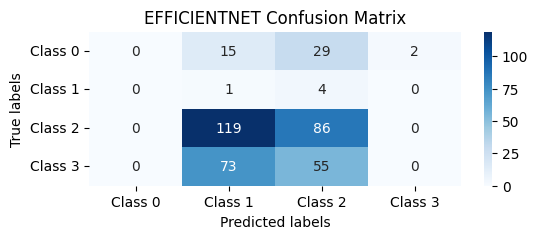

EFFICIENTNET Classification Report:
              precision    recall  f1-score     support
0              0.000000  0.000000  0.000000   46.000000
1              0.004808  0.200000  0.009390    5.000000
2              0.494253  0.419512  0.453826  205.000000
3              0.000000  0.000000  0.000000  128.000000
accuracy       0.226562  0.226562  0.226562    0.226562
macro avg      0.124765  0.154878  0.115804  384.000000
weighted avg   0.263922  0.226562  0.242399  384.000000


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
# Predict probabilities for each class
y_pred_probs = model_efficientnet.predict(X_test)

# Predicted classes
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# True classes
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('EFFICIENTNET Confusion Matrix')
plt.show()

# Print classification report
print("EFFICIENTNET Classification Report:")
report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)

# Convert dictionary to pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Print classification report as table
print(report_df)


# Results ploting

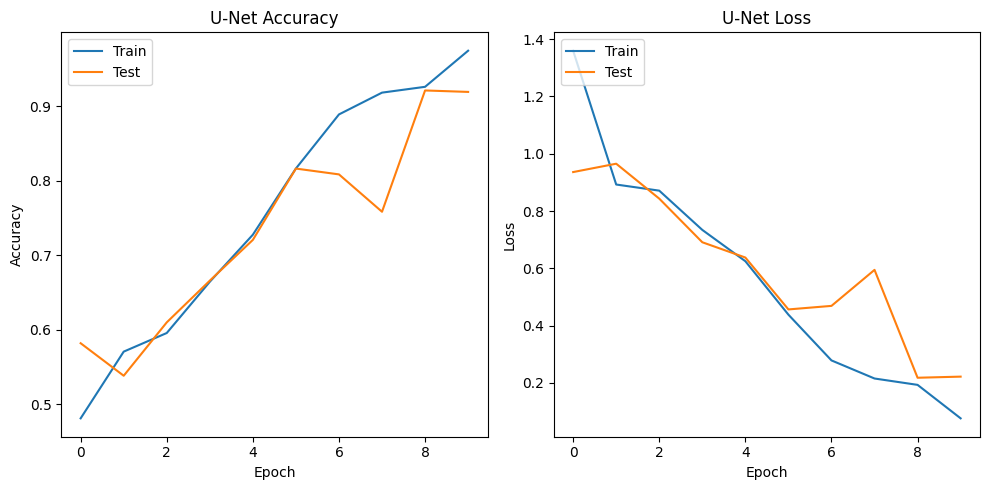

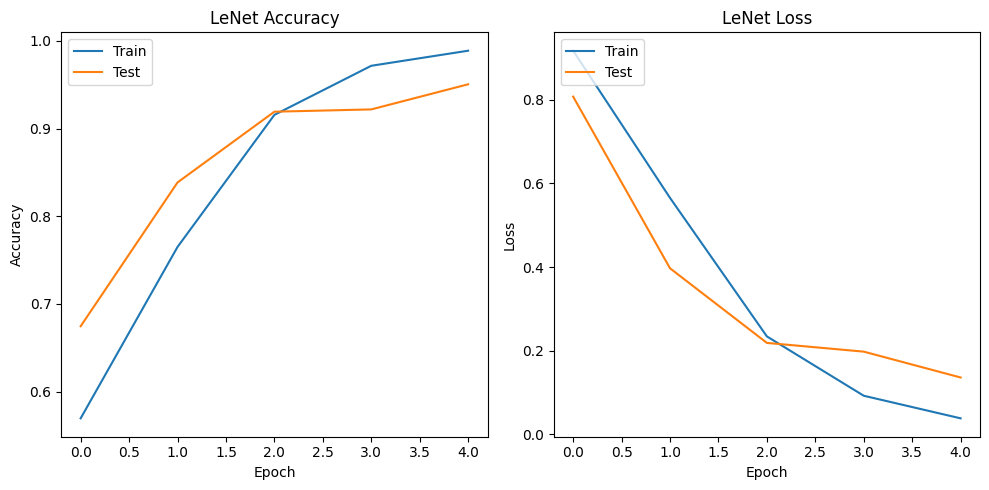

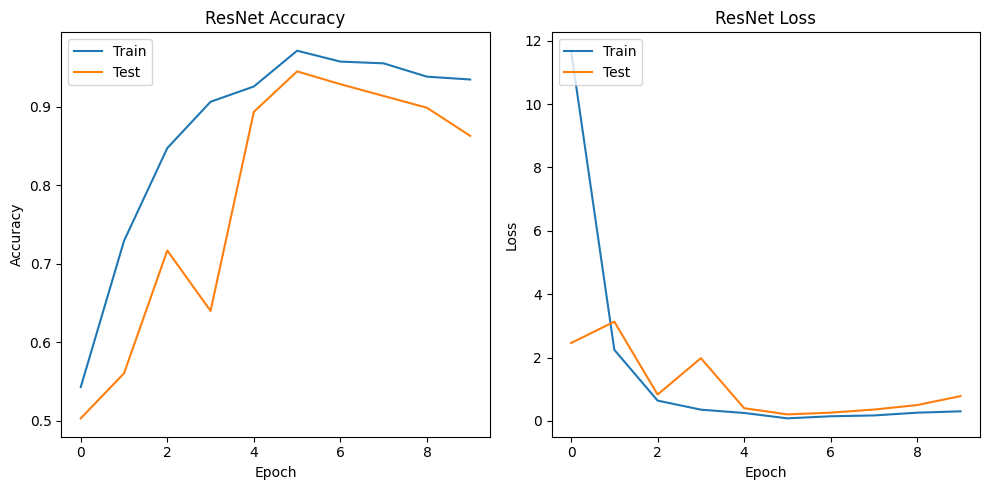

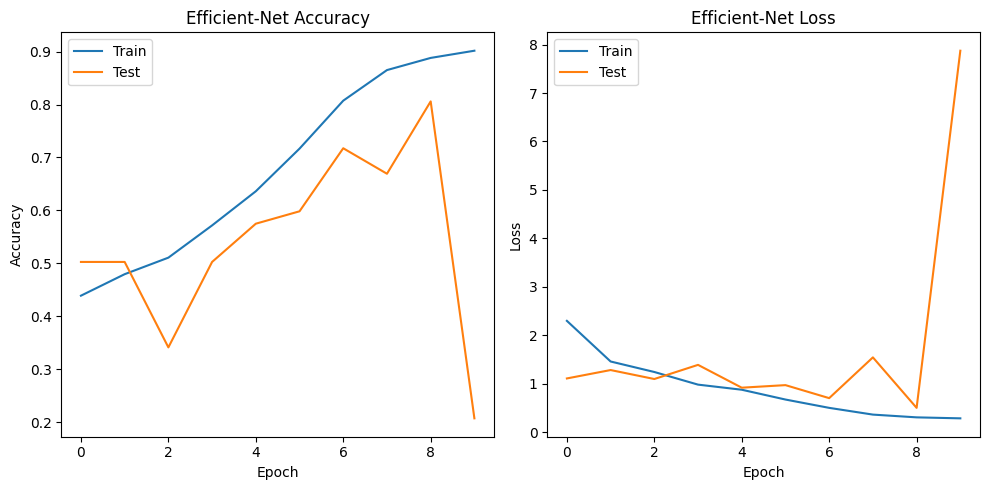

In [94]:
import matplotlib.pyplot as plt

# Define models and their histories (Assuming history_unet and history_lenet exist)
models = [history_unet, history_lenet, history_resnet, history_efficientnet]  # Add more histories as needed

# Define model names for titles
model_names = ['U-Net', 'LeNet', 'ResNet', 'Efficient-Net']  # Add model names accordingly

# Plotting loop
for i, history in enumerate(models):
    plt.figure(figsize=(10, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_names[i]} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_names[i]} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    plt.tight_layout()
    plt.savefig(f'{model_names[i]}_plot.png')
    plt.show()


# Results :

In [95]:
# Define models, their test accuracies, and test losses (assuming these lists are available)
model_names = ['UNet', 'LeNet', 'ResNet', 'EfficientNet']  # Add your model names
test_accuracies = [test_accuracy_unet,
                   test_accuracy_lenet, 
                   test_accuracy_resnet,
                   test_accuracy_efficientnet
                  ]  
test_losses = [test_loss_unet,
                   test_loss_lenet, 
                   test_loss_resnet,
                   test_loss_efficientnet]  # Add test losses for each model

In [96]:
# Create a DataFrame to store model information
import pandas as pd
data = {'Model': model_names, 'Test Accuracy': test_accuracies, 'Test Loss': test_losses}
df = pd.DataFrame(data)

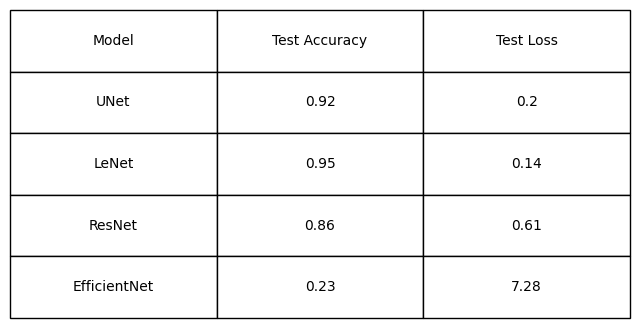

In [97]:
# Format the DataFrame to display values with two decimal points
df_formatted = df.round(2)

# Display the table with limited decimal points
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')
ax.table(cellText=df_formatted.values, colLabels=df_formatted.columns, loc='center', cellLoc='center', bbox=[0, 0, 1, 1])
plt.show()

In [98]:
import numpy as np
from sklearn.metrics import accuracy_score , log_loss
# Calculate predictions for each model
test_predictions_unet = model_unet.predict(X_test)
test_predictions_lenet = model_lenet.predict(X_test)
test_predictions_resnet = model_resnet.predict(X_test)
test_predictions_efficientnet = model_efficientnet.predict(X_test)


# Assuming you have test predictions from each model stored in variables
# test_predictions_unet, test_predictions_lenet, test_predictions_resnet, test_predictions_efficientnet

# Combine predictions into a matrix
ensemble_predictions = np.array([
    test_predictions_unet,
    test_predictions_lenet,
    test_predictions_resnet,
    test_predictions_efficientnet
])

# Aggregate predictions by averaging
ensemble_predictions_avg = np.mean(ensemble_predictions, axis=0)
ensemble_predictions_multiclass = np.argmax(ensemble_predictions_avg, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [99]:

ensemble_predictions_binary = (ensemble_predictions_avg > 0.5).astype(int)

# Evaluate ensemble model
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions_binary)
ensemble_loss = log_loss(y_test, ensemble_predictions_avg)

print("Ensemble Model Accuracy:", ensemble_accuracy)
print("Ensemble Model Loss:", ensemble_loss)


Ensemble Model Accuracy: 0.8802083333333334
Ensemble Model Loss: 0.373716038949448


In [100]:
# Print classification report
print("Ensemble Model Classification Report:")
report_dict = classification_report(y_true_classes, y_pred_classes, output_dict=True)

# Convert dictionary to pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Print classification report as table
print(report_df)

Ensemble Model Classification Report:
              precision    recall  f1-score     support
0              0.000000  0.000000  0.000000   46.000000
1              0.004808  0.200000  0.009390    5.000000
2              0.494253  0.419512  0.453826  205.000000
3              0.000000  0.000000  0.000000  128.000000
accuracy       0.226562  0.226562  0.226562    0.226562
macro avg      0.124765  0.154878  0.115804  384.000000
weighted avg   0.263922  0.226562  0.242399  384.000000


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [101]:
# import joblib

# # Save individual models
# model_unet.save('/kaggle/working/model_unet.h5')
# model_lenet.save('/kaggle/working/model_lenet.h5')
# model_resnet.save('/kaggle/working/model_resnet.h5')
# model_efficientnet.save('/kaggle/working/model_efficientnet.h5')

# # Save ensemble information
# ensemble_info = {
#     'model_names': ['model_unet', 'model_lenet', 'model_resnet', 'model_efficientnet'],
#     'ensemble_predictions': ensemble_predictions_avg,
#     'ensemble_predictions_multiclass': ensemble_predictions_multiclass,
#     'ensemble_predictions_binary': ensemble_predictions_binary,
#     'ensemble_accuracy': ensemble_accuracy,
#     'ensemble_loss': ensemble_loss
# }

# # Serialize ensemble information
# joblib.dump(ensemble_info, '/kaggle/working/ensemble_model.pkl')


In [115]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Average, Input

# Define input shape
input_shape = (150, 150, 3)

# Define input layer
input_layer = Input(shape=input_shape)

# Get outputs of individual models
output_unet = model_unet(input_layer)[0]
output_lenet = model_lenet(input_layer)
output_resnet = model_resnet(input_layer)[0]
output_efficientnet = model_efficientnet(input_layer)

# Average the outputs
averaged_output = Average()([output_unet, output_lenet, output_resnet, output_efficientnet])

# Create ensemble model
new_ensemble_model = Model(inputs=input_layer, outputs=averaged_output)


In [110]:
# import h5py
# from tensorflow.keras.models import save_model

# # Save individual models in .h5 format
# model_unet.save('/kaggle/working/model_unet.h5')
# model_lenet.save('/kaggle/working/model_lenet.h5')
# model_resnet.save('/kaggle/working/model_resnet.h5')
# model_efficientnet.save('/kaggle/working/model_efficientnet.h5')

# # Optionally, save ensemble information in an HDF5 file
# with h5py.File('/kaggle/working/ensemble_model.h5', 'w') as hf:
#     # Save ensemble information
#     hf.create_dataset('model_names', data=['model_unet', 'model_lenet', 'model_resnet', 'model_efficientnet'])
#     hf.create_dataset('ensemble_predictions_avg', data=ensemble_predictions_avg)
#     hf.create_dataset('ensemble_predictions_multiclass', data=ensemble_predictions_multiclass)
#     hf.create_dataset('ensemble_predictions_binary', data=ensemble_predictions_binary)
#     hf.attrs['ensemble_accuracy'] = ensemble_accuracy
#     hf.attrs['ensemble_loss'] = ensemble_loss


In [116]:
from tensorflow.keras.models import save_model

# Save ensemble model with a different name
new_ensemble_model.save('/kaggle/working/new_directory/new_ensemble_model.h5')



ValueError: Unable to synchronously create dataset (name already exists)

**CHECK**

In [ ]:
from PIL import Image
import numpy as np

def preprocess_image(image_path, input_shape):
    # Open the MRI image
    img = Image.open(image_path)
    # Resize the image to match the input shape of the model
    img = img.resize((input_shape[1], input_shape[0]))
    # Convert image to numpy array and normalize pixel values
    img_array = np.array(img) / 255.0
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Get the shape of the preprocessed image
    img_shape = img_array.shape
    return img_array, img_shape

# Example usage:
image_path = '/kaggle/input/mri-alzheimer-dataset/Dataset/Mild_Demented/mild_10.jpg'
input_shape = (150, 150, 3)

# Preprocess the MRI image and get its shape
preprocessed_image, image_shape = preprocess_image(image_path, input_shape)

# Print the shape of the preprocessed image
print("Preprocessed Image Shape:", image_shape)


In [ ]:
import numpy as np

# Assuming preprocessed_image is your image array with shape (1, 150, 150)
preprocessed_image_with_rgb = np.expand_dims(preprocessed_image, axis=-1)  # Add the last dimension

# Repeat the last dimension to create 3 channels for RGB
preprocessed_image_with_rgb = np.repeat(preprocessed_image_with_rgb, 3, axis=-1)

# Now, the shape of preprocessed_image_with_rgb will be (1, 150, 150, 3)
print("Preprocessed Image Shape with RGB:", preprocessed_image_with_rgb.shape)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to make predictions using the ensemble model
def predict_with_ensemble(models, preprocessed_image_with_rgb):
    # Make predictions with each model in the ensemble
    ensemble_predictions = []
    for model in models:
        predictions = model.predict(preprocessed_image_with_rgb)
        ensemble_predictions.append(predictions)
    
    # Combine predictions by averaging
    ensemble_predictions_avg = np.mean(ensemble_predictions, axis=0)
    
    # Get the predicted class with the highest probability
    predicted_class_idx = np.argmax(ensemble_predictions_avg)
    
    # Map predicted class indices to class names
    class_names = {
        0: "Non_Demented",
        1: "Mild_Demented",
        2: "Moderate_Demented",
        3: "Very_Mild_Demented"
    }
    
    # Get the predicted class name
    predicted_class_name = class_names.get(predicted_class_idx, "Unknown")
    
    return predicted_class_name

# Example usage:
input_shape = (150, 150, 3)  # Assuming input shape of the models in the ensemble is (150, 150, 3)
models = [model_unet, model_lenet, model_resnet, model_efficientnet]  # List of models in the ensemble

predicted_class_name = predict_with_ensemble(models, preprocessed_image_with_rgb)


# Now let's print the image
plt.imshow(preprocessed_image_with_rgb[0])
plt.axis('off')
plt.show()

print("Predicted Class:", predicted_class_name)
